In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import numpy as np
from typing import List
import os
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms, utils
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import models

## Utils

Add util functions below when needed

In [7]:
class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='binary'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(10, 5))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)
            ax.set_ylabel('Percentage')
            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

    
    
# Function to visualise class imbalance over batchers
def visualise_dataloader(dl):
    total_num_images = len(dl.dataset)
    class_0_batch_counts = []
    class_1_batch_counts = []

    graph_df = pd.DataFrame({
        'batch_num':[],
        'class_0':[],
        'class_1':[]
    })

    for i, batch in enumerate(dl):
        
        labels = batch[1].tolist()
        unique_labels = set(labels)
        if len(unique_labels) > 2:
            raise ValueError("More than two classes detected")
        
        class_0_count = labels.count(0)
        class_1_count = labels.count(1)

        class_0_batch_counts.append(class_0_count)
        class_1_batch_counts.append(class_1_count)
        
        graph_df.loc[len(graph_df)] = [i+1, class_0_count, class_1_count]
    
    plt.figure(figsize=(10, 6))

    # Bar width
    bar_width = 0.35

    # Plotting bars for class_1
    plt.bar(graph_df['batch_num'], graph_df['class_1'], bar_width, label='Class 1')

    # Plotting bars for class_0
    plt.bar(graph_df['batch_num'] + bar_width, graph_df['class_0'], bar_width, label='Class 0')

    # Adding labels and title
    plt.xlabel('Batch Number')
    plt.ylabel('Number of Images')
    plt.title('Number of Class 1 and Class 0 for Each Batch Number')
    plt.legend()

    plt.tight_layout()
    plt.show()        

# Convert images back to standard size
def denormalize(image_numpy, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image_numpy = (image_numpy * std + mean)
    return image_numpy

def reverse_transform(image_numpy):
    # Define mean and std used for normalization
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalize
    image_numpy = denormalize(image_numpy, mean, std)
    
    # Clip the values to be in the range [0, 1]
    image_numpy = np.clip(image_numpy, 0, 1)
    
    # Convert to PIL image
    #'image_pil = Image.fromarray((image_numpy * 255).astype(np.uint8))
    
    return image_numpy

def evaluate_model_with_images(model, dataloader, threshold=0.5, activation='sigmoid', device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_images = []
    all_probs = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if activation == 'softmax':
                # Softmax
                probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
            elif activation == 'sigmoid':
                # Sigmodid
                probs = torch.sigmoid(outputs)  # Use sigmoid for binary classification
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_images.extend(inputs.cpu().numpy())
    
    # Reverse transformations for all images
    denormalized_images = [reverse_transform(image.transpose(1, 2, 0)) for image in all_images]
    
    return denormalized_images, all_labels, all_probs

def evaluate_model(model, dataloader, activation='sigmoid', device='cpu'):
    model.eval()  # Set the model to evaluation mode
    all_probs = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluating", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            if activation == 'sigmoid':
                probs = torch.sigmoid(outputs)  # Use sigmoid for binary classification
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            elif activation == 'softmax':
                probs = F.softmax(outputs, dim=1)  # Get probabilities for each class
                all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilities of the positive class
                all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_probs

# Find the optimal threshold for F1 score
def find_best_threshold(y_true, probs):
    best_f1 = 0
    best_threshold = 0

    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        predictions = [1 if prob >= threshold else 0 for prob in probs]
        f1 = f1_score(y_true, predictions)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1


def plot_test_images_with_labels(X_test, y_test, predictions=[], probabilities=[], num_images=10, index=0, only_wrong = False, probability = False):
    """
    Plots test images with their true and predicted labels.
    
    Parameters:
    - X_test: Array of test images.
    - y_test: Array of true labels for the test images.
    - predictions: Array of predicted labels for the test images.
    - num_images: Number of images to plot. Default is 10.
    """
    # Ensure num_images doesn't exceed the number of test images
    num_images = min(num_images, len(X_test))
    
    # Create a figure with a grid of subplots
    plt.figure(figsize=(20, 10))
    i = -1
    plotted = 0
    if probability == False:
        while plotted < num_images:
            i+=1
            try:
                if (only_wrong == True) and (y_test[i+index]==predictions[i+index]):
                    continue
            except:
                print("No more images.\n")
                index=0
                i=0
                break
            # Get the image, true label, and predicted label
            img = X_test[i+index]
            true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
            predicted_label = 'War related' if predictions[i+index] == 1 else 'Non war related'
            # Add subplot
            plt.subplot(2, (num_images + 1) // 2, plotted + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {predicted_label}")
            plt.axis('off')
            plotted +=1
        if only_wrong == True:
            print(f'Last plotted image index: {i+index}')
    else:   
        while (plotted < num_images):
            i+=1
            try:
                if (only_wrong == True) and (y_test[i+index]==predictions[i+index]):
                    continue
            except:
                print("No more images.\n")
                index=0
                i=-1
                break
            # Get the image, true label, and predicted label
            img = X_test[i+index]
            true_label = 'War related' if y_test[i+index] == 1 else 'Non war related'
            predicted_label = float(probabilities[i+index])
            # Add subplot
            plt.subplot(2, (num_images + 1) // 2, plotted + 1)
            plt.imshow(img)
            plt.title(f"True: {true_label}\nProb: {predicted_label}")
            plt.axis('off')
            plotted +=1
        if only_wrong == True:
            print(f'Last plotted image index: {i+index+1}')
    
    plt.tight_layout()
    plt.show()

    return index+1+i

# Model Training

## Load the Data

In [ ]:
# Data Loaders

## Training Loop

In [ ]:
# Define a function to train the model
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, patience=3):
    best_loss = float('inf')
    patience_counter= 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for inputs, labels in loop:
            # If we use Sigmoid we should cast to float the labels and add a dimension
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1) 
            # If we use Softmax we should use tensors
            # inputs, labels = inputs.to(device), torch.tensor(labels).to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Print statistics
            running_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad(): # Disable gradient calculation
            for inputs, labels in val_loader:
                # Sigmoid
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1) 
                # Softmax
                # inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()*inputs.size(0)
                
        val_loss /= len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            if not os.path.isdir('./model_weights'):
                os.makedirs('model_weights')
            torch.save(model.state_dict(), 'model_weights/ResNet_best_model_training.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping')
                model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))
                return model
    
    print('\nTraining complete!')
    model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))  # Load the best model at the end
    
    return model

# **Change the data loader function

In [38]:
# Define a function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for inputs, labels in loop:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        val_loss /= len(val_loader.dataset)
        print(f'Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            if not os.path.isdir('./model_weights'):
                os.makedirs('model_weights')
            torch.save(model.state_dict(), 'model_weights/ResNet_best_model_training.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping')
                model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))
                return model

    print('\nTraining complete!')
    model.load_state_dict(torch.load('model_weights/ResNet_best_model_training.pth'))
    return model

In [26]:
# Create sampler for the train to fix class imbalance - note sample weights calculated above
sampler = WeightedRandomSampler(weights=sample_weights, num_samples = len(train_dataset), replacement=True)

# Create a DataLoader
train_loader = DataLoader(train_dataset, sampler = sampler, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## EfficientNet

In [22]:
efficientnetb4 = torchvision.models.efficientnet_b4(weights=("pretrained", models.EfficientNet_B4_Weights.IMAGENET1K_V1))

# Freeze all the parameters
for param in efficientnetb4.parameters():
    param.requires_grad = False

# Change the final layer for binary classification
num_ftrs = efficientnetb4.classifier[1].in_features
efficientnetb4.classifier = torch.nn.Sequential(
            torch.nn.Linear(num_ftrs, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256, 1)
        )

# Move the model to the GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
efficientnetb4 = efficientnetb4.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(efficientnetb4.classifier.parameters(), lr=0.001)

print(efficientnetb4)

/Users/user/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B4_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B4_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [23]:
# Train the model
trained_model=train_model(efficientnetb4, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

Epoch 1/10: 100%|██████████| 114/114 [03:05<00:00,  1.63s/batch, loss=0.489]


Epoch [1/10], Loss: 0.3594
Validation Loss: 0.3433


Epoch 2/10: 100%|██████████| 114/114 [03:00<00:00,  1.58s/batch, loss=0.131]


Epoch [2/10], Loss: 0.2627
Validation Loss: 0.3166


Epoch 3/10: 100%|██████████| 114/114 [02:44<00:00,  1.45s/batch, loss=0.154]


Epoch [3/10], Loss: 0.2208
Validation Loss: 0.2894


Epoch 4/10: 100%|██████████| 114/114 [02:58<00:00,  1.56s/batch, loss=1.3]   


Epoch [4/10], Loss: 0.2035
Validation Loss: 0.3258


Epoch 5/10: 100%|██████████| 114/114 [02:52<00:00,  1.52s/batch, loss=1]     


Epoch [5/10], Loss: 0.1968
Validation Loss: 0.2873


Epoch 6/10:  52%|█████▏    | 59/114 [01:29<01:18,  1.43s/batch, loss=0.235] 

In [ ]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)

# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(test_labels, test_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= best_threshold else 0 for prob in test_probs]

In [ ]:
metrics.run(test_labels, test_preds, "ENet-B4")
metrics.plot()

In [ ]:
if not os.path.isdir('./models/ENet-B4'):
    os.makedirs('./models/ENet-B4')
# Save ResNet50 model weights
torch.save(resnet50.state_dict(), 'models/ENet-B4/ENet-B4.pth')

In [ ]:
index=plot_test_images_with_labels(test_images, test_labels, test_preds, num_images=10, index=50, only_wrong=True)

## ResNet 101_32x8d

In [142]:
resnet101_32 = torchvision.models.resnext101_32x8d(weights=("pretrained", models.ResNeXt101_32X8D_Weights.IMAGENET1K_V1))

# Freeze all the parameters
for param in resnet101_32.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = resnet101_32.fc.in_features
# Define the custom head with two additional dense layers
resnet101_32.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)  # 2 output units for binary classification
)

# Move the model to the GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
resnet101_32 = resnet101_32.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet101_32.fc.parameters(), lr=0.001)

print(resnet101_32)

/Users/user/anaconda3/envs/torch-nightly/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_32X8D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_32X8D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [143]:
# Train the model
trained_model=train_model(resnet101_32, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

Epoch 1/10: 100%|██████████| 114/114 [06:56<00:00,  3.65s/batch, loss=0.397]


Epoch [1/10], Loss: 0.3650
Validation Loss: 0.2438


Epoch 2/10: 100%|██████████| 114/114 [07:13<00:00,  3.81s/batch, loss=0.199]


Epoch [2/10], Loss: 0.3071
Validation Loss: 0.2275


Epoch 3/10: 100%|██████████| 114/114 [06:56<00:00,  3.66s/batch, loss=0.0954]


Epoch [3/10], Loss: 0.2715
Validation Loss: 0.2995


Epoch 4/10: 100%|██████████| 114/114 [06:47<00:00,  3.57s/batch, loss=0.864]


Epoch [4/10], Loss: 0.2636
Validation Loss: 0.2942


Epoch 5/10: 100%|██████████| 114/114 [06:10<00:00,  3.25s/batch, loss=1.22] 


Epoch [5/10], Loss: 0.2478
Validation Loss: 0.4314
Early stopping


In [144]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)

Evaluating: 100%|██████████| 25/25 [01:35<00:00,  3.81s/batch]


In [145]:
# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(test_labels, test_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= best_threshold else 0 for prob in test_probs]

Best Threshold: 0.64


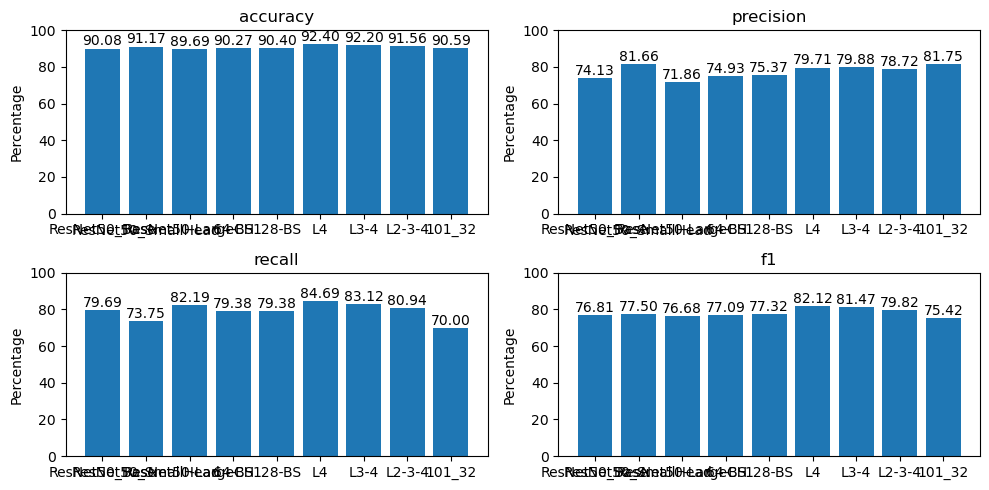

In [146]:
metrics.run(test_labels, test_preds, "101_32")
metrics.plot()

Last plotted image index: 156


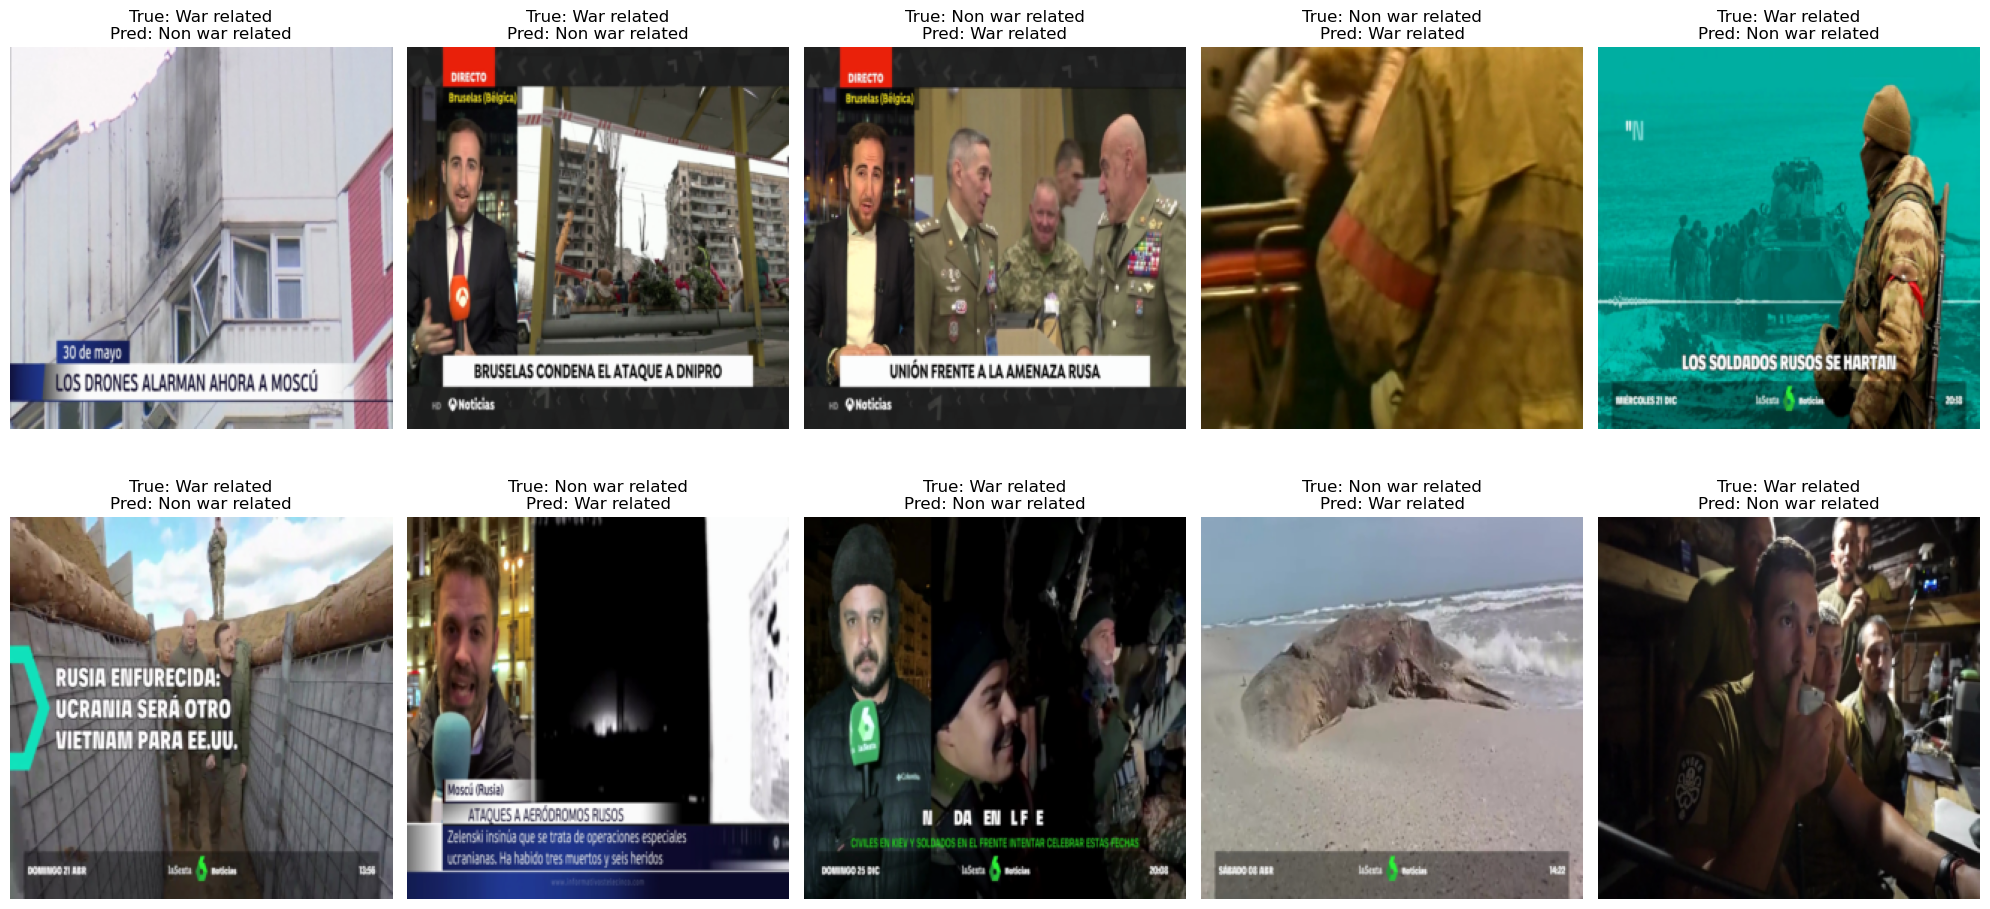

In [147]:
index=plot_test_images_with_labels(test_images, test_labels, test_preds, num_images=10, index=50, only_wrong=True)

In [148]:
# Step 3: Fine-tune the model
for param in resnet101_32.parameters():
    param.requires_grad = False
for param in resnet101_32.layer4.parameters():
    param.requires_grad = True
# for param in resnet101_32.layer3.parameters():
#     param.requires_grad = True

optimizer = optim.Adam(resnet101_32.parameters(), lr=0.0001)  # Lower learning rate for fine-tuning

In [149]:
# Train the model
trained_model=train_model(resnet101_32, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

Epoch 1/10: 100%|██████████| 114/114 [1:24:17<00:00, 44.36s/batch, loss=2.17]  


Epoch [1/10], Loss: 0.1863
Validation Loss: 0.2548


Epoch 2/10: 100%|██████████| 114/114 [1:21:44<00:00, 43.02s/batch, loss=0.192]  


Epoch [2/10], Loss: 0.1109
Validation Loss: 0.2381


Epoch 3/10: 100%|██████████| 114/114 [1:36:23<00:00, 50.73s/batch, loss=0.000892]


Epoch [3/10], Loss: 0.0645
Validation Loss: 0.2094


Epoch 4/10: 100%|██████████| 114/114 [1:40:41<00:00, 53.00s/batch, loss=2.35]   


Epoch [4/10], Loss: 0.0377
Validation Loss: 0.2602


Epoch 5/10:  22%|██▏       | 25/114 [24:26<1:19:55, 53.88s/batch, loss=0.0203]

In [ ]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)

# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(test_labels, test_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= best_threshold else 0 for prob in test_probs]

metrics.run(test_labels, test_preds, "101FT")
metrics.plot()

In [ ]:
index=plot_test_images_with_labels(test_images, test_labels, test_preds, num_images=10, index=50, only_wrong=True)

## ResNet 152

In [ ]:
resnet152 = torchvision.models.resnet152(weights=("pretrained", models.ResNet152_Weights.IMAGENET1K_V1))

# Freeze all the parameters
for param in resnet152.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = resnet152.fc.in_features
# Define the custom head with two additional dense layers
resnet152.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1)  # 2 output units for binary classification
)

# Move the model to the GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
resnet152 = resnet152.to(device)

# Define the loss function and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet152.fc.parameters(), lr=0.001)

print(resnet152)

In [ ]:
# Train the model
trained_model=train_model(resnet152, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)

In [ ]:
test_images, test_labels, test_probs = evaluate_model_with_images(trained_model, test_loader, device=device)

# Calculate the best threshold
best_threshold, best_f1 = find_best_threshold(test_labels, test_probs)
print(f"Best Threshold: {best_threshold}")
# Generate final predictions based on optimal threshold
test_preds = [1 if prob >= best_threshold else 0 for prob in test_probs]

metrics.run(test_labels, test_preds, "152")
metrics.plot()

In [ ]:
index=plot_test_images_with_labels(test_images, test_labels, test_preds, num_images=10, index=50, only_wrong=True)